# Work with the data reduction submodule

## Authors
Zhiyuan Ma

## Learning Goals
* Learn the concept of ``RuntimeContext``, which is the primary interface to run data related tasks.

* Reduce an example TolTEC observation.

## Keywords
Data reduction

## Summary
In this tutorial, we will create a simulated TolTEC observation and reduce it.

To proceed, we need to first setup a tolteca working directory (workdir).

A tolteca workdir is a directory prepared by tolteca, which contains special subdirs
recognized by the tolteca, as well as a set of runtime config
files in YAML format.

Tolteca workdir provides the user experience similar to a python virutal environment.
User can create many workdirs and each has its own configuration setup for a
certain task or project. The configurations are picked up automatically when invoking
``tolteca ...`` command in the shell when in a particular tolteca workdir.

Under the hood, the in-memory representation of a workdir in tolteca is an instance of
`tolteca.utils.RuntimeContext`. All funtionalities related to tolteca workdir are defined
as some methods of this class (or some subclass of it). The runtime context is the
core object that user would be dealing with in tolteca when working in the IPython
prompt or Jupyter notebook.

The first part of the tutorial gives a walk through of the concept of runtime context and
workdir. We will show how to setup from scratch a workdir for running tolteca.simu module
from Cell 1-7. Note that in the tutorial, we create the workdir in a temporary folder, however,
one is encouraged to setup the workdir in his or her own user space, to match the actual use
case. The tolteca.cli module provides a command ``tolteca setup`` to setup a workdir in the
shell:
```text
    $ cd /path/to/hold/workdir
    $ tolteca setup example_tolteca_workdir
    $ cd example_tolteca_workdir && ls  # check the content
    50_setup.yaml  bin/  cal/  log/
```
then one can just copy over one of the example configurations for the simulator
stored in [``tolteca/data/examples/``](https://github.com/toltec-astro/tolteca/tree/master/tolteca/data/examples) to the workdir. Once the workdir is in place and has all
the necessary bits, on can jump right into the second part of the tutorial starting [Cell 8](#cell8).


## Let's first create a runtime context object.

To make the tutorial independent of any user's own system setup, we just use a temporary
directory here:

In [1]:
# import some common packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u

import tempfile
from contextlib import ExitStack  # to manage the tempdir

es = ExitStack()
workdir = es.enter_context(tempfile.TemporaryDirectory())

from tolteca.utils import RuntimeContext

rc = RuntimeContext.from_dir(dirpath=workdir, create=True)

print(f'Created runtime context {rc}')
print(f'Config files in the rc: {rc.config_files}')

Created runtime context RuntimeContext(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml')]


To load the config, just access the ``config`` attribute:

In [2]:
print(f'config: {rc.config}')

SchemaMissingKeyError: Missing key: 'setup'

The reason of the exception is that we have not "setup" the runtime context properly. The setup step is to "initialize" the workdir, so later tolteca runs can recognize the context. To setup,

In [3]:
rc.setup()

from tollan.utils.fmt import pformat_yaml  # pretty print the config
print(pformat_yaml(rc.config))


runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml
setup:
  created_at: 2021-04-27T15:58:00.174
  version: 0.1.dev268+ga76764d



The ``setup()`` method also support adding custom records as follows (note the ``overwrite=True``, otherwise the ``setup()`` will not be on an already setup runtime context):

In [4]:
rc.setup(config={
    'my_info': {'foo': 'bar'},
    'setup': {'baz': 'boo'}
    }, overwrite=True)
print(pformat_yaml(rc.config))


my_info:
  foo: bar
runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml
setup:
  baz: boo
  created_at: 2021-04-27T15:58:00.369
  version: 0.1.dev268+ga76764d



Now we have the workdir setup, we can go back and pretend that we already have a valid tolteca workdir, in which case we can just load the runtime context directly without needing to create and setup again (note how our custom records get loaded as well):

In [5]:
try:
    del rc  # just to make sure we don't get confused with the old rc object.
except Exception:
    pass
rc = RuntimeContext(rootpath=workdir)
print(f'Created runtime context {rc}')
print(f'Config files in the rc: {rc.config_files}')
print(f'Config:\n{pformat_yaml(rc.config)}')

Created runtime context RuntimeContext(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml')]
Config:

my_info:
  foo: bar
runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml
setup:
  baz: boo
  created_at: 2021-04-27T15:58:00.369
  version: 0.1.dev268+ga76764d



## Create simulated data

Tolteca.simu provides a set of tools to create simulated data. To run the simulator, we will need our workdir that we just setup, but with more information.

The tolteca.simu comes with its own subclass of `RuntimeContext`, namely, `SimulatorRuntime`. The simulator runtime manages simulator related configurations loaded from the workdir. To create the simulator runtime, we do the follows:

In [6]:
from tolteca.simu import SimulatorRuntime
rc = SimulatorRuntime(rootpath=workdir)
print(f'Created runtime context {rc}')
print(f'Config files in the rc: {rc.config_files}')
print(f'Config:\n{pformat_yaml(rc.config)}')

Created runtime context SimulatorRuntime(/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg)
Config files in the rc: [PosixPath('/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml')]


SchemaMissingKeyError: Missing key: 'simu'

The reason of the exception is that we have not "setup" the simulator properly. The simulator expects a branch of config entries under the key ``simu``, stored in one of the YAML files found in the workdir.

The tolteca.simu has a set of "built-in" configurations that one can use readily, one of which is 'toltec_point_source'. Let's dump this config to the workdir with file name "60_simu.yaml". Note the format ``\d+_.+.yaml``, this is the convention of the YAML config files to be recongnized by the tolteca runtime context. The files with lower number are overriden by those with higher number.

Note that in the example config, it refers to a filepath ``toltec_sources.asc`` in the ``sources`` list. This is an ASCII table that defines the point sources to be injected on the sky. We need also create this table.

In [7]:
from tolteca.simu import example_configs as cfgs
cfg = cfgs['toltec_point_source']
print(pformat_yaml(cfg))

import yaml
with open(rc.rootpath.joinpath('60_simu.yaml'), 'w') as fo:
    yaml.dump(cfg, fo)

# create the point source catalog
# we just add two sources here. The column names
# used matches with those in the source definition `colname_map`, whose
# keys (a1100, etc) matches with the `grouping: array_name` setting.
from astropy.table import Table
catalog = Table(rows=[
    ['s0', 92., -7., 3., 2., 1.,],
    ['s1', 92., -7.01, 1., 1., 1.,],
    ],
    names=['name', 'ra', 'dec', 'flux_a1100', 'flux_a1400', 'flux_a2000'],
    units=[None, u.deg, u.deg, u.mJy, u.mJy, u.mJy]
    )
catalog.write(rc.rootpath.joinpath('toltec_sources.asc'), format='ascii.ecsv')


simu:
  instrument:
    calobj: cal/calobj_default/index.yaml
    name: toltec
  jobkey: toltec_point_source
  mapping:
    length: '1. arcmin'
    n_scans: 40
    ref_frame: icrs
    rot: '0. deg'
    space: '1.5 arcsec'
    speed: '1. arcmin/s'
    t0: 2020-04-12 00:00:00
    t_turnover: '0.1 s'
    target: '92d -7d'
    type: tolteca.simu:SkyRasterScanModel
  obs_params:
    f_smp_data: '122. Hz'
    f_smp_mapping: '12 Hz'
    t_exp: '1 ct'
  sources:
    - colname_map:
        a1100: flux_a1100
        a1400: flux_a1400
        a2000: flux_a2000
        dec: dec
        name: name
        ra: ra
      filepath: toltec_sources.asc
      grouping: array_name
      type: point_source_catalog



Now we re-visit the ``config`` attribute of the simulator runtime. We should see the new 60_simu.yaml file is suceessfully picked up and no more complains about missing configuration keys.

<a id='cell8'></a>For those returning readers who already have a workdir setup with correct contents, you can start from this cell.

In [8]:
# If you already have a workdir at some path so you can ignore Cells 1-7 and jump in from here: 
# from tolteca.simu import SimulatorRuntime
# workdir = '/the/path/to/a/workdir/with/simu/configs'
# rc = SimulatorRuntime(rootpath=workdir)
print(f'Config:\n{pformat_yaml(rc.config)}')

Config:

my_info:
  foo: bar
runtime:
  bindir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/bin
  caldir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/cal
  logdir: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/log
  rootpath: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg
  setup_file: /private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/50_setup.yaml
setup:
  baz: boo
  created_at: 2021-04-27T15:58:00.369
  version: 0.1.dev268+ga76764d
simu:
  instrument:
    calobj: cal/calobj_default/index.yaml
    name: toltec
  jobkey: toltec_point_source
  mapping:
    length: '1. arcmin'
    n_scans: 40
    ref_frame: icrs
    rot: '0. deg'
    space: '1.5 arcsec'
    speed: '1. arcmin/s'
    t0: 2020-04-12 00:00:00
    t_turnover: '0.1 s'
    target: '92d -7d'
    type: tolteca.simu:SkyRasterScanModel
  mapping_only: false
  obs_params:
    f_smp_data: 122.0 Hz
    f_smp_mapping: 12.0 

The simulator configuration defines the on-the-fly mapping pattern, the input sources, and the instrument to simulate. Under the hood, each of these aspects is managed by its own class which implements the related functionalities.

Let's take a look at the mapping model first. We can make a plot of the mapping pattern:

mapping model:
Model: SkyRasterScanModel
Inputs: ('t',)
Outputs: ('lon', 'lat')
Model set size: 1
Parameters:
    length space  n_scans rot   speed    t_turnover
    arcmin arcsec         deg arcmin / s     s     
    ------ ------ ------- --- ---------- ----------
       1.0    1.5    40.0 0.0        1.0        0.1
time to finish mapping: 43.9 s
mapping target: <SkyCoord (ICRS): (ra, dec) in deg
    (92., -7.)>


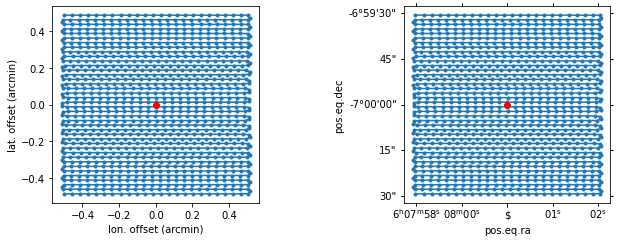

In [9]:

mapping = rc.get_mapping_model()
print(f'mapping model:\n{mapping}')
# the time to finish the mapping can be obtained from the mapping model
mapping_time = mapping.get_total_time()
print(f'time to finish mapping: {mapping_time}')
# to plot the pattern, let's genrate some sampling points
# For plotting, we just use a linspace grid here, but in the actual simulator run
# it makes use of the obs params "f_smp_mapping" as the sampling frequency
t = np.linspace(0, mapping_time, 1000)

mapping_offsets = mapping(t)  # this is the offsets from bore sight

# to evaluate mapping pattern around a coordinates, use evaluate_at
# The frame of input coordinates will be assumed for the offsets
# here the mapping target from the config is given in equitorial
# so the mapping will be along equitorial coordinate frame
target_coord = mapping.target
print(f'mapping target: {mapping.target}')

mapping_coords = mapping.evaluate_at(target_coord, t)

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.7)
# the bore sight offsets
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect('equal')
ax.plot(
    mapping_offsets[0].to_value(u.arcmin),
    mapping_offsets[1].to_value(u.arcmin),
    marker='.',
    )
ax.plot(0, 0, marker='o', color='red')  # the target
ax.set_xlabel('lon. offset (arcmin)')
ax.set_ylabel('lat. offset (arcmin)')

# the sky coords, which we need an fiducial wcs object
# to plot in the ref frame of target coords, i.e., ICRS
from astropy.wcs.utils import celestial_frame_to_wcs
w = celestial_frame_to_wcs(target_coord.frame)
# set the crval to target
w.wcs.crval = np.array([target_coord.ra.degree, target_coord.dec.degree])
ax = fig.add_subplot(1, 2, 2, projection=w)  # a WCSAxes plot, see https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html
ax.set_aspect('equal')
ax.plot(
    mapping_coords.ra.degree,
    mapping_coords.dec.degree,
    transform=ax.get_transform('icrs'),
    marker='.',
    )
ax.plot(
    target_coord.ra.degree, target_coord.dec.degree,
    transform=ax.get_transform('icrs'),
    marker='o', color='red',
    )
ax.coords[0].set_ticklabel(exclude_overlapping=True)  # reduce the cluttering of tick labels.

For the input sources, the ``sources`` list specified in the simulator configs is parsed and a set of `tolteca.simu.base.SourceModel` subclass instances are created according to the ``type`` key. In this case, we only have one model with type ``point_source_catalog``. It is specified in format of an ASCII table, which we just created:

sources: [<SourceCatalogModel(name='/private/var/folders/zc/33kgh8vx3z37kpp6xf84bzvm0000gn/T/tmpp2mhtbbg/toltec_sources.asc')>]
model class is:
<class 'tolteca.simu.base.SourceCatalogModel'>
Name: SourceCatalogModel
N_inputs: 2
N_outputs: 1
model data:
a1100 a1400 a2000  dec  name  ra 
 mJy   mJy   mJy   deg       deg 
----- ----- ----- ----- ---- ----
  3.0   2.0   1.0  -7.0   s0 92.0
  1.0   1.0   1.0 -7.01   s1 92.0
model source positions: <SkyCoord (ICRS): (ra, dec) in deg
    [(92., -7.  ), (92., -7.01)]>


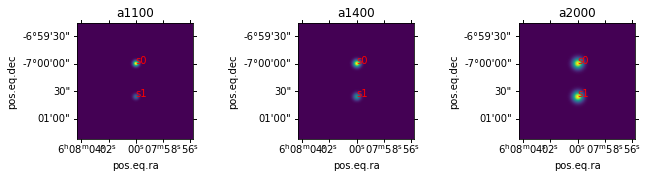

In [10]:
sources = rc.get_source_model()
print(f'sources: {sources}')
m_point_source = sources[0]  # take out the point source model and let's take a look
print(f'model class is:\n{type(m_point_source)}')
print(f'model data:\n{m_point_source.data}')
print(f'model source positions: {m_point_source.pos}')
# we can make a synetic image and plot by creating a SourceImageModel from the SourceCatalogModel
# to do this we need some beammodels and a pixelscale.
# we can use the toltec beammodels here, and assume a 1"/pix scale
from tolteca.simu.toltec import BeamModel
m_img = m_point_source.make_image_model(beam_models=BeamModel().models, pixscale=1 << u.arcsec / u.pix)
# the m_img is a SourceImageModel class which contains image data as a dict of ImageHDU.
# we create a set of WCSAxes to plot them

from astropy.wcs import WCS

fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(wspace=0.9)
n_hdus = len(m_img.data)

for i, (k, hdu) in enumerate(m_img.data.items()):
    w = WCS(hdu.header)
    ax = fig.add_subplot(1, n_hdus, i + 1, projection=w)
    ax.set_aspect('equal')
    ax.set_title(f'{k}')
    ax.imshow(hdu.data)
    # label the sources
    for p, n in zip(m_point_source.pos, m_point_source.data['name']):
        ax.text(p.ra.degree, p.dec.degree, n, transform=ax.get_transform('icrs'), color='red')

The ``instrument`` ties the mapping model and the source models together, and drives generating of simulated data. `tolteca.simu.base.SimulatorBase` defines the abstract interface for implementing the simulator engine. A subclass needs to be implemented to make simulated observations for an instrument. For the TolTEC simulator, this is `tolteca.simu.toltec.ToltecSimulator` and `tolteca.simu.toltec.ToltecPolarimetrySimulator`

In the config, the simulator engine is specified by the ``instrument`` key. In our example config, this is set to `toltec`:

In [15]:
simobj = rc.get_instrument_simulator()
print(simobj)
simobj.table

invalid calibration object index file path, fallback to default


uid,nw,pg,loc,ori,fg,design_group,i,j,k,x,y,f,flag,flag_summary,array_name,background,bkg_temp,responsivity,passband,wl_center,fp,fr,Qr,g0,g1,g,phi_g,f0,k0,k1,m0,m1,flxscale,x_t,y_t
,,,,,,,,,,um,um,GHz,,,,pW,K,1 / pW,GHz,cm,GHz,GHz,,,,,,GHz,1 / Hz,1 / Hz,,,,deg,deg
str10,int64,int64,int64,int64,int64,str3,int64,int64,int64,float64,float64,float64,int64,str7,str5,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,float64,float64,float64
00_0_169_0,0,0,169,0,0,PXA,0,31,1,-22000.0,-61920.816,0.51677,1,dark,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.51677,0.51677,10000.0,200,0,200,0,0.51677,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.01154409322948823
00_0_169_1,0,0,169,1,2,PXA,0,31,343,-22000.0,-61920.816,0.736856,1,dark,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.736856,0.736856,10000.0,200,0,200,0,0.736856,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.01154409322948823
00_1_170_0,0,1,170,0,1,PXB,0,33,172,-19250.0,-61920.816,0.608774,0,active,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.608774,0.608774,10000.0,200,0,200,0,0.608774,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.010101081575802202
00_1_170_1,0,1,170,1,3,PXB,0,33,514,-19250.0,-61920.816,0.864924,0,active,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.864924,0.864924,10000.0,200,0,200,0,0.864924,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.010101081575802202
00_0_163_0,0,0,163,0,0,PXA,0,35,7,-16500.0,-61920.816,0.519749,0,active,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.519749,0.519749,10000.0,200,0,200,0,0.519749,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.008658069922116172
00_0_163_1,0,0,163,1,2,PXA,0,35,349,-16500.0,-61920.816,0.741011,0,active,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.741011,0.741011,10000.0,200,0,200,0,0.741011,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.008658069922116172
00_1_159_0,0,1,159,0,1,PXB,0,37,183,-13750.0,-61920.816,0.615225,0,active,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.615225,0.615225,10000.0,200,0,200,0,0.615225,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.0072150582684301435
00_1_159_1,0,1,159,1,3,PXB,0,37,525,-13750.0,-61920.816,0.873886,0,active,a1100,10.01,9.64,5.794e-05,65.0,0.10999999999999999,0.873886,0.873886,10000.0,200,0,200,0,0.873886,0.0,0.0,0,0,17259.233690024164,-0.03249180330681757,-0.0072150582684301435
